# **Second project Probabilistic Programming**

Ghadamiyan Lida 407 AI

This project consists in implementing a bayesian neural network, which is a neural network with a prior distribution on its weights, and the ouput is denoted by random variables distributed Bernoulli for binary classification and Categorical for multicalss classification.

#Imports

In [1]:
!pip install pymc

In [2]:
#Loading libraries                                                         
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
import tensorflow as tf 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop 
import os
from tensorflow.keras.models import load_model
from pymc3.theanof import MRG_RandomStreams, set_tt_rng

import numpy as np
import math
import pandas as pd 

from sklearn.preprocessing import scale
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white") 

In [4]:
! pip install arviz

# Binary Data set


The first data set that I am using for this project creates a binary and non-linear classification problem, as it can be seen in the plot below

In [5]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42, shuffle = True)

No handles with labels found to put in legend.


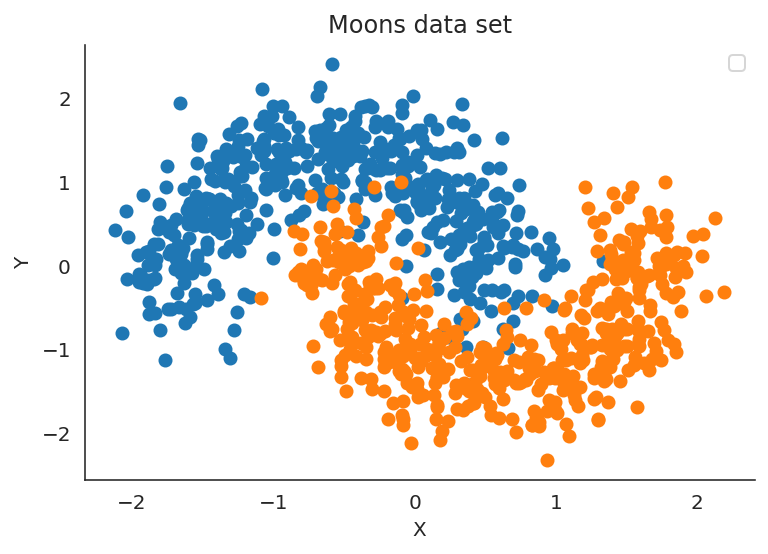

In [6]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1])
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Moons data set');

# Binary Bayesian Neural Network

I implemented this model following the indications presented in the document and using some informations regarding the model and the ADVI from the official PyMC site ("https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html")

## Building the model

This function defines a probabilistic model that creates a neural network with two fully connected hidden layers, each of them having 'hidden_layers' number of neurons on them.

The maneer in which the NN is created is the one requested, and that is the following:

- the prior on the wheights and biases is the standard normal N(0,1)

- the last layer has only one sigmoid neuron

- the output is a Bernoulli variable, as it is suitable for a binary classification problem.

In [7]:
# function for building the binary bayesian neural network
def build_bbnn(bbnn_input, bbnn_output, nn_input, nn_output, hidden_layers):

    with pm.Model() as bneural_network:
        bbnn_input = pm.Data("bbnn_input", bbnn_input)
        bbnn_output = pm.Data("bbnn_output", bbnn_output)

        # Prior on weights and biases 

        # Prior on biases
        biases = pm.Normal('biases', 0, 1, shape = (2, ))

        # Prior on weights from input to the hidden layer
        weights1 = pm.Normal("weights1", 0, 1, shape=(nn_input.shape[1], hidden_layers), 
                            testval = np.random.randn(nn_input.shape[1], hidden_layers)*np.sqrt(2/hidden_layers).astype(floatX))

        # Prior on weights from the first to the second hidden layer
        weights2 = pm.Normal("weights2", 0, 1, shape=(hidden_layers, hidden_layers), 
                            testval = np.random.randn(hidden_layers, hidden_layers)*np.sqrt(2/hidden_layers).astype(floatX))

        # Prior on weights from the hidden layer to the output
        weightsOut = pm.Normal("weightsOut", 0, 1, shape=(hidden_layers,), 
                            testval = np.random.randn(hidden_layers)*np.sqrt(2/hidden_layers).astype(floatX))

        # Hyperbolic tangent as activation function
        activation1 = pm.math.tanh(pm.math.dot(bbnn_input, weights1) + biases[0])
        activation2 = pm.math.tanh(pm.math.dot(activation1, weights2) + biases[1])
        activationOut = pm.math.sigmoid(pm.math.dot(activation2, weightsOut))

        # Bernoulli likelihood for binary classification
        likelihood = pm.Bernoulli("likelihood", activationOut, observed = bbnn_output, total_size = len(nn_output))
    return bneural_network


In [8]:
bneural_network = build_bbnn(X_train, Y_train, X_train, Y_train, 15)

## Fitting

Fitting the Bayesian Neural Network with Automatic Differentiation Variational Inference (ADVI) which approximates the posterior distribution by variational distribution.

In [9]:
set_tt_rng(MRG_RandomStreams(42))

In [10]:
with bneural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=5000, method=inference)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 420.86: 100%|██████████| 5000/5000 [00:16<00:00, 295.38it/s]
Finished [100%]: Average Loss = 420.5


## Predicting

Predicting using 'sample_posterior_predictive()' that generates new predictions from the posterior, which is from the ADVI.

In [11]:
trace = approx.sample(draws=100)

In [12]:
# Create the posterior of the test data
x = T.matrix("X")
n = T.iscalar("n")

# Using Theano symbolic input and function to get the posterior of the  test data
x.tag.test_value = np.empty_like(X_test[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    bneural_network.likelihood.distribution.p, size=n, more_replacements={bneural_network["bbnn_input"]: x}
)
sample_proba = theano.function([x, n], _sample_proba, on_unused_input='warn')

In [13]:
pred = sample_proba(X_test, 1000).mean(0) > 0.5

## Evaluating the model

In [14]:
print("Accuracy: ", accuracy_score(Y_test, pred))

Accuracy:  0.83


In [15]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81       137
         1.0       0.85      0.84      0.84       163

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



In [16]:
M = confusion_matrix(Y_test, pred)

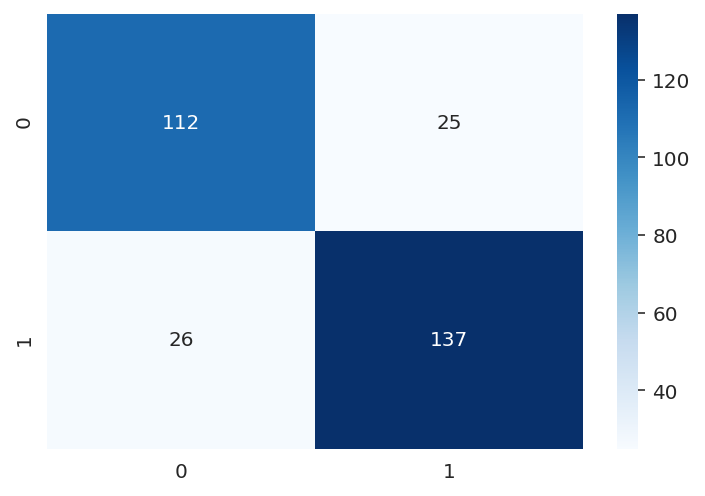

In [17]:
ax = sns.heatmap(confusion_matrix(Y_test, pred), annot = np.array([[str(M[0,0]), str(M[0,1])],[str(M[1,0]), str(M[1,1])]]), cmap=plt.cm.Blues, fmt = '')

# Classic Binary Neural Network

The clasical NN has the same arhitecture as the BNN, having 2 fully connected hidden layers and tanh with sigmoid as activation functions. It also have a droput layer with a learning rate of 0.2 .

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, input_dim = X_train.shape[1], kernel_initializer = 'normal', activation = 'tanh'), # we add a fully connected layer with 500 units using tanh as activation function
    tf.keras.layers.Dense(500, kernel_initializer = 'normal', activation = 'tanh'), # we add a fully connected layer with 512 units using tanh as activation function
    tf.keras.layers.Dropout(0.2), # we add a dropout layer with the dropout rate 0.2
    tf.keras.layers.Dense(2, kernel_initializer = 'normal', activation = 'sigmoid') # we add a fully connected layer with 2 units (the number of classes) using sigmoid as activation function
])

In [19]:
# define the optimizer, set the learning rate and the momentum (for SGD with momentum)
optimizer = SGD(lr=0.001, momentum=0.9)  

# compile the model specifying the optimizer, the loss and the metrics (as an array).
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 

In [21]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model.{epoch:05d}.hdf5'
)

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

In [23]:
model.fit(X_train[:-200], Y_train[:-200],
          epochs=10, batch_size=32, initial_epoch=0,
          callbacks=[checkpoint_callback, tensorboard_callback],
          validation_data=(X_train[:-200], Y_train[:-200])) 

Epoch 1/10
16/16 [==============================] - 1s 30ms/step - loss: 0.6046 - accuracy: 0.8752 - val_loss: 0.5045 - val_accuracy: 0.8860
Epoch 2/10
16/16 [==============================] - 0s 12ms/step - loss: 0.4684 - accuracy: 0.8791 - val_loss: 0.3890 - val_accuracy: 0.8840
Epoch 3/10
16/16 [==============================] - 0s 12ms/step - loss: 0.3757 - accuracy: 0.8811 - val_loss: 0.3314 - val_accuracy: 0.8800
Epoch 4/10
16/16 [==============================] - 0s 14ms/step - loss: 0.3157 - accuracy: 0.8964 - val_loss: 0.3019 - val_accuracy: 0.8820
Epoch 5/10
16/16 [==============================] - 0s 13ms/step - loss: 0.2895 - accuracy: 0.8863 - val_loss: 0.2859 - val_accuracy: 0.8820
Epoch 6/10
16/16 [==============================] - 0s 12ms/step - loss: 0.3042 - accuracy: 0.8614 - val_loss: 0.2757 - val_accuracy: 0.8860
Epoch 7/10
16/16 [==============================] - 0s 13ms/step - loss: 0.2873 - accuracy: 0.8581 - val_loss: 0.2686 - val_accuracy: 0.8860
Epoch 8/10
16

In [24]:
best_epoch = 10
best_model = load_model('./checkpoints/model.%05d.hdf5' % best_epoch)
predicted_test_labels_scores_n = best_model.predict(X_test)
predicted_test_labels_n = np.argmax(predicted_test_labels_scores_n, axis=-1)
accuracy_n = accuracy_score(predicted_test_labels_n, Y_test)
print('accuracy = ', accuracy_n)

accuracy =  0.8233333333333334


In [25]:
print(classification_report(Y_test, predicted_test_labels_n))

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       137
         1.0       0.84      0.84      0.84       163

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



In [26]:
M = confusion_matrix(Y_test, predicted_test_labels_n,)

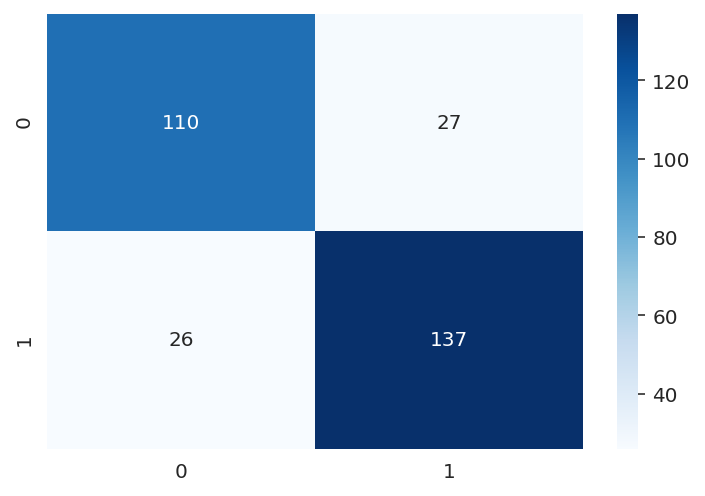

In [27]:
ax = sns.heatmap(confusion_matrix(Y_test, predicted_test_labels_n,), annot = np.array([[str(M[0,0]), str(M[0,1])],[str(M[1,0]), str(M[1,1])]]), cmap=plt.cm.Blues, fmt = '')

# Sanity check

The sanity check is a linearly separable data. The points are the same as earlier, but the labels asre as it is shown below.

In [28]:
Xdata = np.random.randn(100, 2)
Y = np.tanh(X[:, 0] + X[:, 1])
Y = 1. / (1. + np.exp(-(Y + Y)))
Y = Y > 0.5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

No handles with labels found to put in legend.


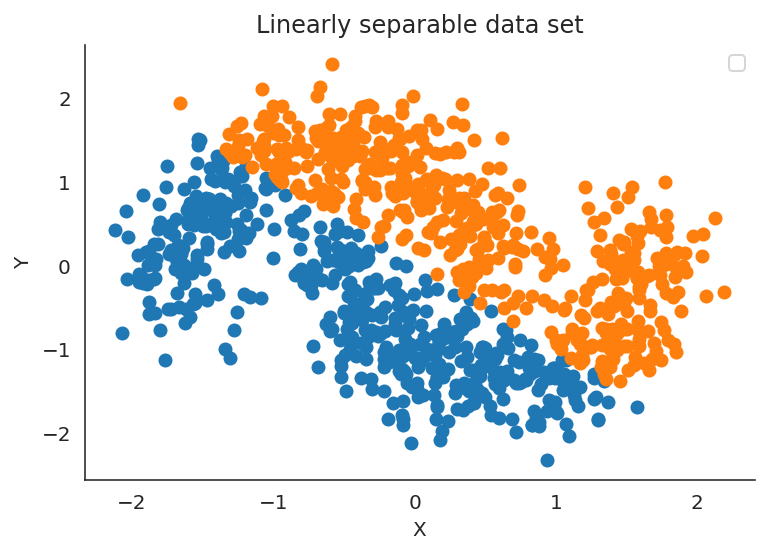

In [36]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1])
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Linearly separable data set');

## Bayesian Nerural Network

In [30]:
bneural_network = build_bbnn(X_train, Y_train, X_train, Y_train, 5)
set_tt_rng(MRG_RandomStreams(42))

with bneural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=5000, method=inference)
trace = approx.sample(draws=100)

x = T.matrix("X")
n = T.iscalar("n")

x.tag.test_value = np.empty_like(X_test[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    bneural_network.likelihood.distribution.p, size=n, more_replacements={bneural_network["bbnn_input"]: x}
)
sample_proba = theano.function([x, n], _sample_proba, on_unused_input='ignore')
pred = sample_proba(X_test, 1000).mean(0) > 0.5

Average Loss = 401.01: 100%|██████████| 5000/5000 [00:08<00:00, 581.46it/s]
Finished [100%]: Average Loss = 400.7


In [31]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99        93
        True       0.99      1.00      1.00       107

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



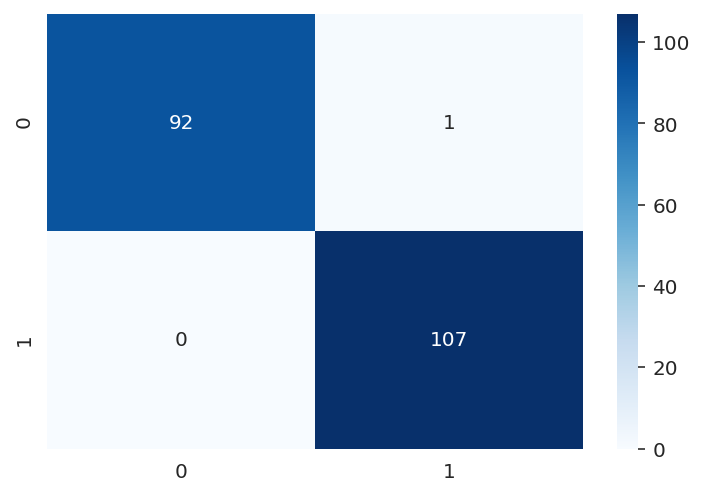

In [32]:
M = confusion_matrix(Y_test, pred)
ax = sns.heatmap(confusion_matrix(Y_test, pred),annot = np.array([[str(M[0,0]), str(M[0,1])],[str(M[1,0]), str(M[1,1])]]), cmap=plt.cm.Blues, fmt = '')

## Clasic Neural Network

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, input_dim = X_train.shape[1], kernel_initializer = 'normal', activation = 'tanh'), # we add a fully connected layer with 500 units using tanh as activation function
    tf.keras.layers.Dense(500, kernel_initializer = 'normal', activation = 'tanh'),                               # we add a fully connected layer with 500 units using tanh as activation function
    tf.keras.layers.Dropout(0.2),                                                                                 # we add a dropout layer with the dropout rate 0.2
    tf.keras.layers.Dense(2, kernel_initializer = 'normal', activation = 'sigmoid')                               # we add a fully connected layer with 2 units (the number of classes) using sigmoid as activation function
])

optimizer = SGD(lr=0.001, momentum=0.9)  
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 
    
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model.{epoch:05d}.hdf5'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

model.fit(X_train[:-20], Y_train[:-20],
          epochs=10, batch_size=32, initial_epoch=0,
          callbacks=[checkpoint_callback, tensorboard_callback],
          validation_data=(X_train[:-20], Y_train[:-20])) 

best_epoch = 10
best_model = load_model('./checkpoints/model.%05d.hdf5' % best_epoch)
predicted_test_labels_scores_n = best_model.predict(X_test)
predicted_test_labels_n = np.argmax(predicted_test_labels_scores_n, axis=-1)
accuracy_n = accuracy_score(predicted_test_labels_n, Y_test)
print('accuracy = ', accuracy_n)

Epoch 1/10
25/25 [==============================] - 1s 24ms/step - loss: 0.7258 - accuracy: 0.4116 - val_loss: 0.5810 - val_accuracy: 0.9936
Epoch 2/10
25/25 [==============================] - 0s 12ms/step - loss: 0.5402 - accuracy: 0.9584 - val_loss: 0.4334 - val_accuracy: 0.9513
Epoch 3/10
25/25 [==============================] - 0s 11ms/step - loss: 0.4063 - accuracy: 0.9513 - val_loss: 0.3467 - val_accuracy: 0.9474
Epoch 4/10
25/25 [==============================] - 0s 13ms/step - loss: 0.3313 - accuracy: 0.9560 - val_loss: 0.2899 - val_accuracy: 0.9603
Epoch 5/10
25/25 [==============================] - 0s 13ms/step - loss: 0.2795 - accuracy: 0.9731 - val_loss: 0.2496 - val_accuracy: 0.9718
Epoch 6/10
25/25 [==============================] - 1s 34ms/step - loss: 0.2419 - accuracy: 0.9833 - val_loss: 0.2199 - val_accuracy: 0.9756
Epoch 7/10
25/25 [==============================] - 0s 13ms/step - loss: 0.2127 - accuracy: 0.9728 - val_loss: 0.1972 - val_accuracy: 0.9808
Epoch 8/10
25

In [34]:
print(classification_report(Y_test, predicted_test_labels_n))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98        93
        True       0.97      1.00      0.99       107

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



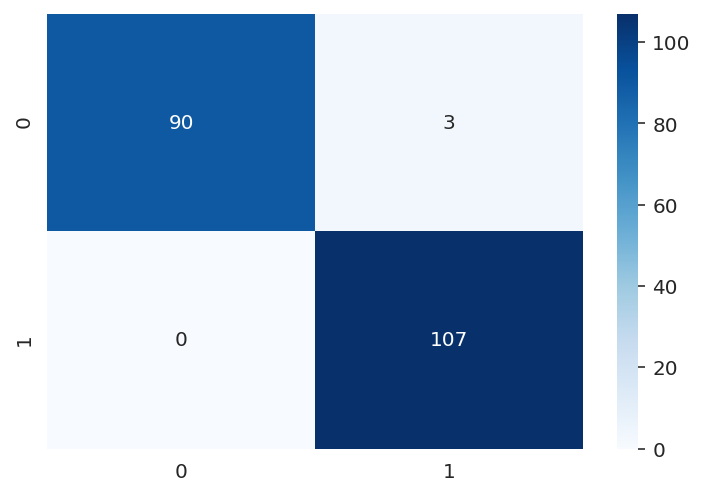

In [35]:
M = confusion_matrix(Y_test, predicted_test_labels_n)
ax = sns.heatmap(confusion_matrix(Y_test, predicted_test_labels_n), annot = np.array([[str(M[0,0]), str(M[0,1])],[str(M[1,0]), str(M[1,1])]]), cmap=plt.cm.Blues, fmt = '')

# Sources

"https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78"

"https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html"

"https://notebook.community/arrigonialberto86/funtime/Variational_inference_colab"